In [106]:
import numpy as np
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [107]:
def load_mnist():
    mnist = fetch_openml('mnist_784', version=1, as_frame=False)
    X = mnist.data.astype(np.float32) / 255.0
    y = mnist.target.astype(np.int8)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

    return X_train, y_train, X_test, y_test, X_val, y_val

In [108]:
class Tensor:
    def __init__(self, data, requires_grad=False, grad_fn="Leaf"):
        self.data = data
        self.requires_grad = requires_grad
        self._backward = None
        self.parents = []
        self.grad = None
        self.grad_fn = grad_fn
        
    def __repr__(self):
        return f"Tensor(data={self.data}, requires_grad={self.requires_grad}, grad_fn={self.grad_fn})"
        
    def backward(self, grad=None):
        if grad is None:
            if self.data.size == 1:
                grad = np.ones_like(self.data)
            else:
                raise RuntimeError("grad must be specified for non-scalar tensor")
        self.grad = grad
        
        visited = set()
        topo_order = []
        
        def build_topo(tensor):
            if tensor not in visited:
                visited.add(tensor)
                for parent in tensor.parents:
                    build_topo(parent)
                topo_order.append(tensor)
                
        build_topo(self)
        
        for tensor in reversed(topo_order):
            if tensor._backward is not None:
                tensor._backward()
            
    def __add__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data + other.data, requires_grad=self.requires_grad or other.requires_grad, grad_fn="Add")
        
        def _backward():
            if self.requires_grad:
                if self.data.ndim == 0: 
                    grad_self = out.grad.sum()
                elif self.data.ndim < out.grad.ndim:
                    grad_self = out.grad.sum(axis=0)
                else:
                    grad_self = out.grad
                self.grad = self.grad + grad_self if self.grad is not None else grad_self
            
            if other.requires_grad:
                if other.data.ndim == 0: 
                    grad_other = out.grad.sum()
                elif other.data.ndim < out.grad.ndim:
                    grad_other = out.grad.sum(axis=0)
                else:
                    grad_other = out.grad
                other.grad = other.grad + grad_other if other.grad is not None else grad_other
        
        out._backward = _backward
        out.parents = [self, other]
        return out
        
    def __matmul__(self, other):
        other = other if isinstance(other, Tensor) else Tensor(other)
        out = Tensor(self.data @ other.data, requires_grad=self.requires_grad or other.requires_grad, grad_fn="MatMul")
        
        def _backward():
            if self.requires_grad:
                self.grad = self.grad + out.grad @ other.data.T if self.grad is not None else out.grad @ other.data.T
            if other.requires_grad:
                other.grad = other.grad + self.data.T @ out.grad if other.grad is not None else self.data.T @ out.grad         
        
        out._backward = _backward
        out.parents = [self, other]
        return out
    
    def relu(self):
        out = Tensor(np.maximum(0, self.data), requires_grad=self.requires_grad, grad_fn="ReLU")
        
        def _backward():
            if self.requires_grad:
                self.grad = self.grad + out.grad * (out.data > 0) if self.grad is not None else out.grad * (out.data > 0)
        
        out._backward = _backward
        out.parents = [self]
        return out

In [109]:
class Module:
    def __init__(self):
        self._parameters = []

    def parameters(self):
        return self._parameters

    def __call__(self, *args, **kwargs):
        return self.forward(*args, **kwargs)

class Linear(Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = Tensor(np.random.randn(in_features, out_features) * np.sqrt(2. / in_features), requires_grad=True)
        self.bias = Tensor(np.zeros(out_features), requires_grad=True)
        self._parameters = [self.weight, self.bias]

    def forward(self, x):
        return x @ self.weight + self.bias
    
class ReLU(Module):
    def forward(self, x):
        return x.relu()
    
class Sequential(Module):
    def __init__(self, *layers):
        super().__init__()
        self.layers = layers
        for layer in layers:
            self._parameters.extend(layer.parameters())

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def train(self):
        for layer in self.layers:
            if hasattr(layer, 'train'):
                layer.train()

    def eval(self):
        for layer in self.layers:
            if hasattr(layer, 'eval'):
                layer.eval()

In [110]:
class SGD:
    def __init__(self, parameters, lr=0.01):
        self.parameters = parameters
        self.lr = lr

    def step(self):
        for p in self.parameters:
            if p.grad is not None:
                p.data -= self.lr * p.grad

    def zero_grad(self):
        for p in self.parameters:
            p.grad = None

In [111]:
class BatchNorm(Module):
    def __init__(self, num_features, momentum=0.1, epsilon=1e-5):
        super().__init__()
        self.gamma = Tensor(np.ones(num_features), requires_grad=True)
        self.beta = Tensor(np.zeros(num_features), requires_grad=True)
        self.running_mean = Tensor(np.zeros(num_features), requires_grad=False)
        self.running_var = Tensor(np.ones(num_features), requires_grad=False)
        self.momentum = momentum
        self.epsilon = epsilon
        self.training = True
        self._parameters = [self.gamma, self.beta]

    def forward(self, x):
        if self.training:
            mean = x.data.mean(axis=0)
            var = x.data.var(axis=0)
            x_norm = (x.data - mean) / np.sqrt(var + self.epsilon)
            out_data = self.gamma.data * x_norm + self.beta.data
            self.running_mean.data = self.momentum * mean + (1 - self.momentum) * self.running_mean.data
            self.running_var.data = self.momentum * var + (1 - self.momentum) * self.running_var.data 
            out = Tensor(out_data, requires_grad=True, grad_fn="BatchNorm")
            out.parents = [x, self.gamma, self.beta]
            out._backward = lambda: self._backward(out, x, mean, var)
            return out
        else:
            x_norm = (x.data - self.running_mean.data) / np.sqrt(self.running_var.data + self.epsilon)
            out_data = self.gamma.data * x_norm + self.beta.data
            return Tensor(out_data)

    def _backward(self, out, x, mean, var):
        N = x.data.shape[0]
        x_norm = (x.data - mean) / np.sqrt(var + self.epsilon)
        dgamma = np.sum(out.grad * x_norm, axis=0)
        dbeta = np.sum(out.grad, axis=0)
        dx_norm = out.grad * self.gamma.data
        dvar = np.sum(dx_norm * (x.data - mean) * -0.5 / (var + self.epsilon)**1.5, axis=0)
        dmean = np.sum(dx_norm * -1 / np.sqrt(var + self.epsilon), axis=0) + dvar * np.sum(-2 * (x.data - mean), axis=0) / N
        dx = dx_norm / np.sqrt(var + self.epsilon) + dvar * 2 * (x.data - mean) / N + dmean / N
        
        if x.requires_grad:
            x.grad = x.grad + dx if x.grad is not None else dx
        if self.gamma.requires_grad:
            self.gamma.grad = self.gamma.grad + dgamma if self.gamma.grad is not None else dgamma
        if self.beta.requires_grad:
            self.beta.grad = self.beta.grad + dbeta if self.beta.grad is not None else dbeta

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

In [112]:

class CrossEntropyLoss(Module):
    def __init__(self, dim=-1):
        super().__init__()
        self.dim = dim

    def forward(self, inputs, targets):
        max_val = np.max(inputs.data, axis=self.dim, keepdims=True)
        logsumexp = np.log(np.sum(np.exp(inputs.data - max_val), axis=self.dim, keepdims=True)) + max_val
        log_probs = inputs.data - logsumexp
        batch_size = inputs.data.shape[0]
        targets = targets.data.astype(int) if isinstance(targets, Tensor) else targets.astype(int)
        loss = -np.mean(log_probs[np.arange(batch_size), targets])
        out = Tensor(loss, requires_grad=inputs.requires_grad, grad_fn="CrossEntropyLoss")
        out.parents = [inputs]
        out._backward = lambda: self._backward(out, inputs, log_probs, targets)
        return out

    def _backward(self, out, inputs, log_probs, targets):
        if inputs.requires_grad:
            batch_size = inputs.data.shape[0]
            grad = np.exp(log_probs) 
            grad[np.arange(batch_size), targets] -= 1
            grad /= batch_size
            inputs.grad = inputs.grad + grad if inputs.grad is not None else grad

In [113]:
def get_batches(X, y, batch_size):
    num_samples = X.shape[0]
    indices = np.arange(num_samples)
    np.random.shuffle(indices)
    for start in range(0, num_samples, batch_size):
        end = min(start + batch_size, num_samples)
        batch_indices = indices[start:end]
        yield X[batch_indices], y[batch_indices]
        
def compute_accuracy(y_true, y_pred):
    correct = np.sum(y_true == y_pred)
    total = len(y_true)
    return correct / total if total > 0 else 0.0

def compute_f1_scores(y_true, y_pred, num_classes=10):
    f1_scores = np.zeros(num_classes)
    for class_idx in range(num_classes):
        tp = np.sum((y_pred == class_idx) & (y_true == class_idx))
        fp = np.sum((y_pred == class_idx) & (y_true != class_idx))
        fn = np.sum((y_pred != class_idx) & (y_true == class_idx))
        
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
        
        if precision + recall > 0:
            f1_scores[class_idx] = 2 * (precision * recall) / (precision + recall)
        else:
            f1_scores[class_idx] = 0.0
    
    return f1_scores

In [114]:
X_train, y_train, X_test, y_test, X_val, y_val = load_mnist()

model = Sequential(
    Linear(784, 128),
    BatchNorm(128),
    ReLU(),
    Linear(128, 64),
    BatchNorm(64),
    ReLU(),
    Linear(64, 10)
)

optimizer = SGD(model.parameters(), lr=0.01)
criterion = CrossEntropyLoss()

num_epochs = 20
batch_size = 64

train_losses = []
val_losses = []

for epoch in range(1,num_epochs+1):
    model.train()
    train_loss = 0
    for X_batch, y_batch in get_batches(X_train, y_train, batch_size):
        X_batch = Tensor(X_batch)
        y_batch = Tensor(y_batch)
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.data * X_batch.data.shape[0]
    train_loss /= X_train.shape[0]
    train_losses.append(train_loss)

    model.eval()
    val_loss = 0
    y_pred = []
    y_true = []
    for X_batch, y_batch in get_batches(X_val, y_val, batch_size):
        X_batch = Tensor(X_batch)
        y_batch = Tensor(y_batch)
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        val_loss += loss.data * X_batch.data.shape[0]
        preds = np.argmax(outputs.data, axis=1)
        y_pred.extend(preds)
        y_true.extend(y_batch.data)
    val_loss /= X_val.shape[0]
    val_losses.append(val_loss)

    y_pred = np.array(y_pred)
    y_true = np.array(y_true)
    accuracy = compute_accuracy(y_true, y_pred)
    f1 = compute_f1_scores(y_true, y_pred, num_classes=10)
    
    print(f"Epoch {epoch}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}")
    print("F1 Scores per class:", f1)

Epoch 1/20, Train Loss: 0.6376, Val Loss: 0.3192, Accuracy: 0.9217
F1 Scores per class: [0.95369618 0.96267191 0.9095315  0.91247095 0.92216582 0.89128631
 0.9265233  0.93133047 0.89632653 0.89974726]
Epoch 2/20, Train Loss: 0.2985, Val Loss: 0.2242, Accuracy: 0.9400
F1 Scores per class: [0.95961228 0.97361478 0.9405053  0.93538462 0.93127148 0.92039801
 0.93772894 0.94781987 0.93053312 0.91311475]
Epoch 3/20, Train Loss: 0.2317, Val Loss: 0.1797, Accuracy: 0.9521
F1 Scores per class: [0.96512571 0.98280423 0.94942904 0.943769   0.94619983 0.93521595
 0.95168642 0.96034607 0.95116093 0.92614108]
Epoch 4/20, Train Loss: 0.1939, Val Loss: 0.1553, Accuracy: 0.9562
F1 Scores per class: [0.96763754 0.98412698 0.95517522 0.95034377 0.93916024 0.94068505
 0.96073059 0.96843615 0.95610535 0.93057851]
Epoch 5/20, Train Loss: 0.1676, Val Loss: 0.1396, Accuracy: 0.9587
F1 Scores per class: [0.96763754 0.9828496  0.95921697 0.95591647 0.95017182 0.94352159
 0.9594229  0.96764917 0.95763389 0.93553

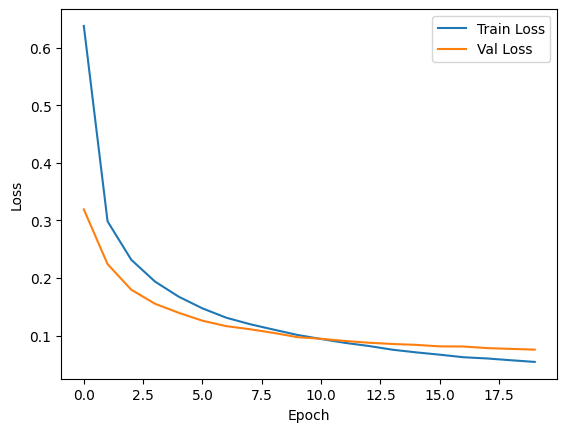

In [115]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [116]:
model.eval()
y_pred = []
y_true = []
for X_batch, y_batch in get_batches(X_test, y_test, batch_size):
    X_batch = Tensor(X_batch)
    y_batch = Tensor(y_batch)
    outputs = model(X_batch)
    preds = np.argmax(outputs.data, axis=1)
    y_pred.extend(preds)
    y_true.extend(y_batch.data)

y_pred = np.array(y_pred)
y_true = np.array(y_true)
test_accuracy = compute_accuracy(y_true, y_pred)
test_f1 = compute_f1_scores(y_true, y_pred, num_classes=10)
print("Test Accuracy:", test_accuracy)
print("Test F1 Scores per class:", test_f1)

Test Accuracy: 0.9712857142857143
Test F1 Scores per class: [0.98680352 0.98252185 0.96312684 0.96179183 0.97310513 0.97103659
 0.97862933 0.9716263  0.95639535 0.96742897]
